In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
from scipy.optimize import minimize
from lteanalysis import LTEAnalysis
import pandas as pd

In [3]:
# ----- input -----
# for LTE calculation
line  = 'c18o'
Xconv = 1e-7
delv  = 0.2 # km/s
ilines = [3,2] # Ju
Ncols = np.array([5.e16, 5.9e16, 5.e17]) # cm^-2  
Texes = np.array([5, 18, 22, 30]) # K

In [4]:
def cost_function(params, X, Y, model):

    # print("printing params", params)
    N, T = params[0]*1e19, params[1]*50
    X_predicted = model.get_intensity(line = line, Ju = ilines[0], Ncol = N, Tex = T, delv = 0.5, Xconv = Xconv),
    Y_predicted = model.get_intensity(line = line, Ju = ilines[1], Ncol = N, Tex = T, delv = 0.5, Xconv = Xconv)
    error = np.sum((X_predicted - X)**2 + (Y_predicted - Y)**2)

    return error

In [5]:
# Initiate Model

lte_model = LTEAnalysis()
lte_model.read_lamda_moldata(line)

In [6]:
# Read data

df_blue = pd.read_csv(filepath_or_buffer='Tb_dict_blueshifted_side.csv', sep=',', header='infer')

# print(df_blue)

In [8]:
# Get T_exe and N_col for all points

T_exe_on_pix = []
N_col_on_pix = []
optimization_flag_on_pix = []

initial_params = [1.e15/1.e19, 30./50.]         # N, T guess

for i in range(len(df_blue)):

    # print("Estimating T at R = ", df_blue["R_arcsec"][i])

    result = minimize(cost_function, initial_params, args=(df_blue["Tb_on_pix_b7"][i], df_blue["Tb_on_pix_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})

    # print('Optimization successful: ', result.success)
    if not result.success:
        print("Estimating T at R = ", df_blue["R_arcsec"][i])
        print('Optimization successful: ', result.success)
        print("Cause - ", result.message)

    N_col_on_pix.append(float(result.x[0])*1.e19)
    T_exe_on_pix.append(float(result.x[1])*50.)
    optimization_flag_on_pix.append(result.success)

df_blue.loc[:,"N_col_on_pix"] = np.array(N_col_on_pix)
df_blue.loc[:,"T_exe_on_pix"] = np.array(T_exe_on_pix)
df_blue.loc[:,"optimization_flag_on_pix"] = np.array(optimization_flag_on_pix)


Estimating T at R =  -0.18000000005721
Estimating T at R =  -0.18000000005721
Estimating T at R =  -0.24000000007628
Estimating T at R =  -0.24000000007628
Estimating T at R =  -0.24000000007628
Estimating T at R =  -0.24000000007628
Estimating T at R =  -0.30000000009535
Estimating T at R =  -0.30000000009535
Estimating T at R =  -0.36000000011442
Estimating T at R =  -0.36000000011442
Estimating T at R =  -0.42000000013349
Estimating T at R =  -0.48000000015256
Estimating T at R =  -0.48000000015256
Estimating T at R =  -0.54000000017163
Estimating T at R =  -0.66000000020977
Estimating T at R =  -0.72000000022884
Estimating T at R =  -0.84000000026698
Estimating T at R =  -0.96000000030512
Estimating T at R =  -1.14000000036233
Estimating T at R =  -1.32000000041954
Estimating T at R =  -1.62000000051489
Estimating T at R =  -1.98000000062931
Estimating T at R =  -2.46000000078187
Estimating T at R =  -3.18000000101071
Estimating T at R =  -4.32000000137304
Estimating T at R =  -6.0

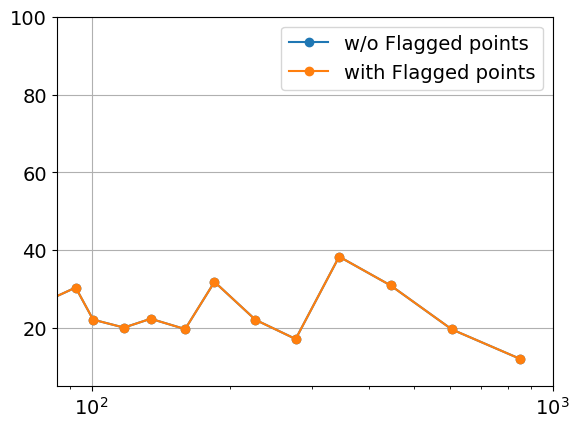

In [9]:
df_blue_on_pix = df_blue.drop(df_blue[df_blue['optimization_flag_on_pix'] == False].index)

fig, axes = plt.subplots()
axes.plot(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["T_exe_on_pix"], marker='o', label = 'w/o Flagged points')
axes.plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes.get_xaxis().set_minor_formatter(formatter)
axes.set_xlim(84, 1000)
axes.set_ylim(5,100)
axes.set_xscale('log')
axes.grid(True)
axes.legend()

plt.show()

In [22]:
# Read data

df_red = pd.read_csv(filepath_or_buffer='Tb_dict_redshifted_side.csv', sep=',', header='infer')

# print(df_blue)

In [28]:
# Get T_exe and N_col for all points

T_exe_on_pix = []
N_col_on_pix = []
optimization_flag_on_pix = []

T_exe_max_pix = []
N_col_max_pix = []
optimization_flag_max_pix = []

T_exe_max_pix_fix_r = []
N_col_max_pix_fix_r = []
optimization_flag_max_pix_fix_r = []


initial_params = [1.e15/1.e19, 30./50.]         # N, T guess

for i in range(len(df_red)):

    # print("Estimating T at R = ", df_blue["R_arcsec"][i])

    result_on_pix = minimize(cost_function, initial_params, args=(df_red["Tb_on_pix_b7"][i], df_red["Tb_on_pix_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})
    
    result_max_pix = minimize(cost_function, initial_params, args=(df_red["Tb_max_pix_rs_b7"][i], df_red["Tb_max_pix_rs_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})
        
    result_max_pix_fix_r = minimize(cost_function, initial_params, args=(df_red["Tb_max_pix_b7_rs_fix_r"][i], df_red["Tb_max_pix_b6_rs_fix_r"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})

    # print('Optimization successful: ', result.success)
    if not result_on_pix.success:
        print("Estimating T at R = ", df_red["R_arcsec"][i])
        print("uing on pixel meassurement")
        print('Optimization successful: ', result_on_pix.success)
        print("Cause - ", result_on_pix.message)

    if not result_max_pix.success:
        print("Estimating T at R = ", df_red["R_arcsec"][i])
        print("uing on pixel meassurement")
        print('Optimization successful: ', result_max_pix.success)
        print("Cause - ", result_max_pix.message)

    N_col_on_pix.append(float(result_on_pix.x[0])*1.e19)
    T_exe_on_pix.append(float(result_on_pix.x[1])*50.)
    optimization_flag_on_pix.append(result_on_pix.success)

    N_col_max_pix.append(float(result_max_pix.x[0])*1.e19)
    T_exe_max_pix.append(float(result_max_pix.x[1])*50.)
    optimization_flag_max_pix.append(result_max_pix.success)

    N_col_max_pix_fix_r.append(float(result_max_pix.x[0])*1.e19)
    T_exe_max_pix_fix_r.append(float(result_max_pix.x[1])*50.)
    optimization_flag_max_pix_fix_r.append(result_max_pix.success)

df_red.loc[:,"N_col_on_pix"] = np.array(N_col_on_pix)
df_red.loc[:,"T_exe_on_pix"] = np.array(T_exe_on_pix)
df_red.loc[:,"optimization_flag_on_pix"] = np.array(optimization_flag_on_pix)

df_red.loc[:,"N_col_max_pix"] = np.array(N_col_max_pix)
df_red.loc[:,"T_exe_max_pix"] = np.array(T_exe_max_pix)
df_red.loc[:,"optimization_flag_max_pix"] = np.array(optimization_flag_max_pix)

df_red.loc[:,"N_col_max_pix_fix_r"] = np.array(N_col_max_pix_fix_r)
df_red.loc[:,"T_exe_max_pix_fix_r"] = np.array(T_exe_max_pix_fix_r)
df_red.loc[:,"optimization_flag_max_pix_fix_r"] = np.array(optimization_flag_max_pix_fix_r)


e:\Mihir_new\ASIAA-SSP\LTEAnalysis\lteanalysis\_lteanalysis.py:483: RuntimeWarning: overflow encountered in exp
  Zarray = np.array([gJ[j]*np.exp(-EJ[j]/Tex) for j in range(len(J))])


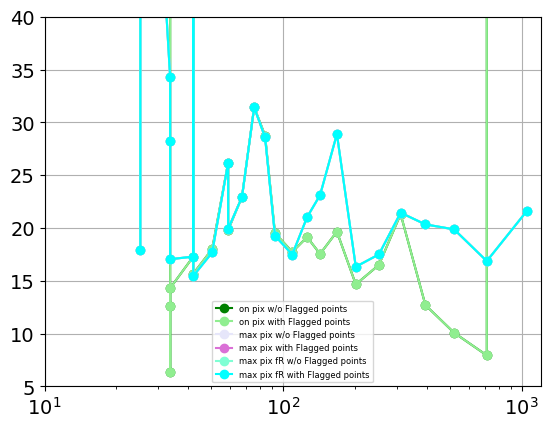

In [31]:
df_red_on_pix = df_red.drop(df_red[df_red['optimization_flag_on_pix'] == False].index)

df_red_max_pix = df_red.drop(df_red[df_red['optimization_flag_max_pix'] == False].index)

df_red_max_pix_fix_r = df_red.drop(df_red[df_red['optimization_flag_max_pix_fix_r'] == False].index)

fig, axes = plt.subplots()

axes.plot(df_red_on_pix["R_arcsec"]*140., df_red_on_pix["T_exe_on_pix"], marker='o', label = 'on pix w/o Flagged points', color = 'green')
axes.plot(df_red["R_arcsec"]*140., df_red["T_exe_on_pix"], marker='o', label = 'on pix with Flagged points', color = 'lightgreen')

axes.plot(df_red_max_pix["R_arcsec"]*140., df_red_max_pix["T_exe_max_pix"], marker='o', label = 'max pix w/o Flagged points', color = 'lavender')
axes.plot(df_red["R_arcsec"]*140., df_red["T_exe_max_pix"], marker='o', label = 'max pix with Flagged points', color = 'orchid')

axes.plot(df_red_max_pix_fix_r["R_arcsec"]*140., df_red_max_pix_fix_r["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR w/o Flagged points', color = 'aquamarine')
axes.plot(df_red["R_arcsec"]*140., df_red["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR with Flagged points', color = 'aqua')


formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes.get_xaxis().set_minor_formatter(formatter)
axes.set_xlim(10, 1200)
axes.set_ylim(5,40)
axes.set_xscale('log')
axes.grid(True)
axes.legend(prop={'size': 6})

plt.show()